<a href="https://colab.research.google.com/github/tamnol/DeepLearning-AI/blob/master/sunpots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2

In [38]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [40]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2019-10-03 05:48:29--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2019-10-03 05:48:29 (5.13 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



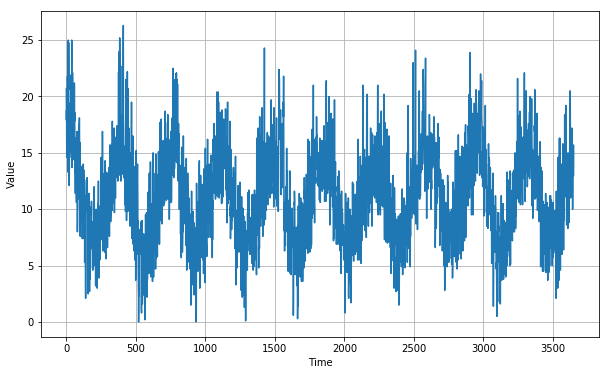

In [41]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
    file_read = csv.reader(csvfile, delimiter =',')
    next(file_read)
    i = 0
    for row in file_read: 
      temps.append(float(row[1]))
      time_step.append(i)
      i = i + 1
     
 

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [54]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters= 32, kernel_size= 5, strides=1, 
                                                           padding='same',activation="relu", 
                                                           input_shape=[None, 1]),
                                    tf.keras.layers.LSTM(64, return_sequences=True),
                                    tf.keras.layers.LSTM(64, return_sequences=True),
                                    tf.keras.layers.Dense(30, activation="relu"),
                                    tf.keras.layers.Dense(10, activation="relu"),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 400)
                                    ])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 8s 799ms/step - loss: 32.5567 - mae: 33.0582
Epoch 2/100
10/10 [==============================] - 5s 468ms/step - loss: 31.9272 - mae: 32.4302
Epoch 3/100
10/10 [==============================] - 5s 471ms/step - loss: 31.0186 - mae: 31.4477
Epoch 4/100
10/10 [==============================] - 5s 468ms/step - loss: 29.7358 - mae: 30.2106
Epoch 5/100
10/10 [==============================] - 5s 470ms/step - loss: 28.1208 - mae: 28.6831
Epoch 6/100
10/10 [==============================] - 5s 470ms/step - loss: 26.2800 - mae: 26.7419
Epoch 7/100
10/10 [==============================] - 5s 460ms/step - loss: 23.7627 - mae: 24.2522
Epoch 8/100
10/10 [==============================] - 5s 470ms/step - loss: 20.7149 - mae: 21.1184
Epoch 9/100
10/10 [==============================] - 5s 467ms/step - loss: 17.0066 - mae: 17.3608
Epoch 10/100
10/

[1e-08, 0.0001, 0, 60]

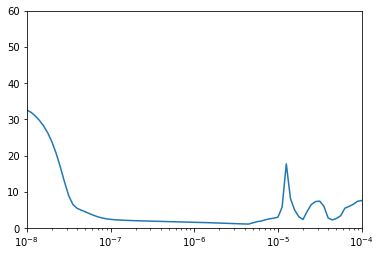

In [55]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [56]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters= 64, kernel_size= 5, strides=1, 
                                                           padding='causal',activation="relu", input_shape=[None, 1]),
                                    
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.Dense(30, activation="relu"),
                                    tf.keras.layers.Dense(10, activation="relu"),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 400)])

optimizer = tf.keras.optimizers.SGD(lr= 1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 8s 327ms/step - loss: 5.0979 - mae: 5.6375
Epoch 2/150
25/25 [==============================] - 5s 189ms/step - loss: 2.2425 - mae: 2.6983
Epoch 3/150
25/25 [==============================] - 5s 190ms/step - loss: 2.0245 - mae: 2.4785
Epoch 4/150
25/25 [==============================] - 5s 188ms/step - loss: 1.9427 - mae: 2.3969
Epoch 5/150
25/25 [==============================] - 5s 189ms/step - loss: 1.9203 - mae: 2.3728
Epoch 6/150
25/25 [==============================] - 5s 189ms/step - loss: 1.9092 - mae: 2.3626
Epoch 7/150
25/25 [==============================] - 5s 189ms/step - loss: 1.8974 - mae: 2.3505
Epoch 8/150
25/25 [==============================] - 5s 188ms/step - loss: 1.8883 - mae: 2.3400
Epoch 9/150
25/25 [==============================] - 5s 188ms/step - loss: 1.8812 - mae: 2.3318
Epoch 10/150
25/25 [==============================] - 5s 189ms/step - loss: 1.8728 - mae: 2.3248
Epoch 11/150
25/25 [===================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

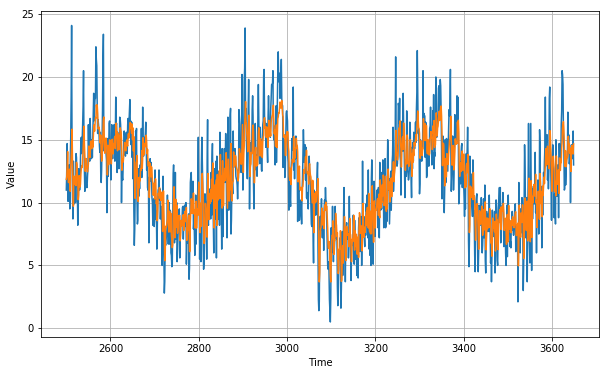

In [58]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [59]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.804681

In [60]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.850505 12.042244 13.040243 ... 13.931889 13.870489 14.670452]
